#  Connecting to PostgreSQL database using SQLAlchemy

This notebook contains the sample code from my medium blog post titled: How to build a PostgreSQL database and connect to with SQLAlchemy

The SQL code used to create the database can be found on my GitHub: https://github.com/rebekah999/Data-Analysis-Portfolio/blob/6f8d5ff7438b60e6e573989b701090e0255ea3fe/SPY_DB.sql

## Database ERD

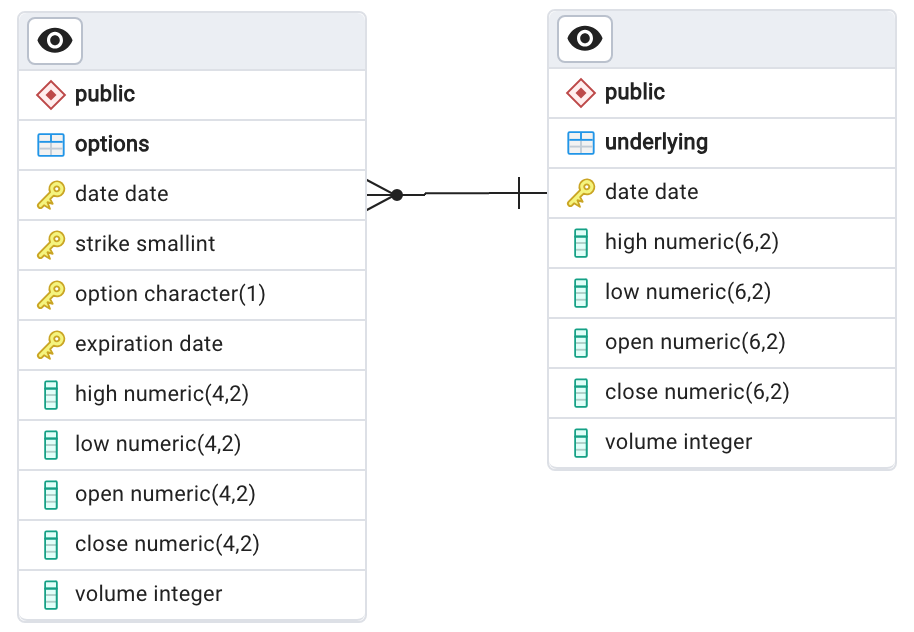

In [1]:
from IPython.display import Image

image_path = 'SPY_ERD.png'

# Displaying ERD
Image(filename=image_path , width=500)


In [2]:
# Package imports
import numpy as np
import pandas as pd

from sqlalchemy import create_engine, MetaData, Table, select

In [3]:
def underlying_PKs(engine):
    """
    Returns a list of primary keys that are already stored in the underlying table in the SPY database.

            Parameters:
                    engine (sqlalchemy.engine.base.Engine): SQLAlchemy Engine object used to connect to the database.

            Returns:
                    list of str: List of primary keys (dates) stored in the underlying table.
    """

    underlying_PKs = [] 

    metadata = MetaData(bind=engine)  
    underlying_table = Table('underlying', metadata, autoload=True) 

    # Execute a select query to retrieve all rows
    select_query = select([underlying_table.c.date]) 
    """
    PostgreSQL equivalent:
    SELECT date FROM underlying;
    """
    result = engine.execute(select_query) 

    # Fetch and store the primary keys (dates) to the underlying_PKs variable
    for row in result:
        underlying_PKs.append(str(row[0]))
    
    return underlying_PKs


In [4]:
def load_underlying(underlying_data, stored_underlying_PKs, database_password, engine):
    """
    Uploads data to underlying table in SPY database.

            Parameters:
                    underlying_data (pandas.DataFrame): DataFrame containing the underlying stock data to be uploaded.
                    stored_underlying_PKs (list of str): List of primary keys (dates) already stored in the underlying table.
                    database_password (str): Password for accessing the PostgreSQL database.
                    engine (sqlalchemy.engine.base.Engine): SQLAlchemy Engine object used to connect to the database.

            Returns:
                    None
    """

        
    filtered_data = underlying_data[~underlying_data["date"].isin(stored_underlying_PKs)]
    if len(filtered_data) == 0:
        print("Nothing new to add")
    else:
        # Load the DataFrame into the PostgreSQL database
        filtered_data.to_sql('underlying', engine, if_exists='append', index=False)
        print("Data successfully uploaded to underlying table")
    

In [5]:
def options_PKs(engine):
    """
        Returns a dictionary containing lists of primary keys that are already stored in the options table in the SPY database.

                Parameters:
                        engine (sqlalchemy.engine.base.Engine): SQLAlchemy Engine object used to connect to the database.

                Returns:
                        dict: Dictionary containing lists of primary keys for each column in the options table:
                            - 'date' (list): List of date primary keys.
                            - 'strike' (list): List of strike primary keys.
                            - 'option' (list): List of option primary keys.
                            - 'expiration' (list): List of expiration primary keys.
    """

    
    options_PKs = {'date': list(), 'strike': list(), 'option': list(), 'expiration': list()} 

    # Reflect the existing database schema
    metadata = MetaData(bind=engine)
    options_table = Table('options', metadata, autoload=True)

    # Execute a select query to retrieve all rows
    select_query = select([options_table.c.date, options_table.c.strike,
                           options_table.c.option, options_table.c.expiration])
    """
    PostgreSQL equivalent:
    SELECT date, strike, option, expiration FROM options;
    """
    result = engine.execute(select_query)

    # Fetch and store the primary keys (dates) to the options_PKs variable
    for row in result:
        options_PKs["date"].append(str(row[0]))
        options_PKs["strike"].append(str(row[1]))
        options_PKs["option"].append(str(row[2]))
        options_PKs["expiration"].append(str(row[3]))
    
    return options_PKs

In [16]:
def load_options(options_data, stored_options_PKs, database_password, engine):
    """
        Loads option data into the options table in the SPY database.

                Parameters:
                        options_data (pandas.DataFrame): DataFrame containing option data to be uploaded.
                        stored_options_PKs (dict): Dictionary containing lists of primary keys already stored in the options table.
                        database_password (str): Password for accessing the PostgreSQL database.
                        engine (sqlalchemy.engine.base.Engine): SQLAlchemy Engine object used to connect to the database.

                Returns:
                        None
    """

    
    date_mask = ~options_data["date"].isin(stored_options_PKs["date"])
    strike_mask = ~options_data["strike"].isin(stored_options_PKs["strike"])
    option_mask = ~options_data["option"].isin(stored_options_PKs["option"])
    expiration_mask = ~options_data["expiration"].isin(stored_options_PKs["expiration"])
    
    filtered_data = options_data[date_mask & strike_mask & option_mask & expiration_mask]

    if len(filtered_data) == 0:
        print("Nothing new to add")
    else:
        # Load the DataFrame into the PostgreSQL database
        filtered_data.to_sql('options', engine, if_exists='append', index=False)
        print("Data successfully uploaded to options table")

In [7]:
# Data was acquired by running my S&P 500 Database Pipeline project
# The repositoy with the code can be found on my Github: https://github.com/rebekah999/Data-Analysis-Portfolio/blob/aa1a4b8651b173571780576950b718a2aa044308/%20S%26P%20500%20Database%20Pipeline.ipynb

# Load data to pandas Dataframes
underlying_df = pd.read_csv("underlying_data.csv")
options_df = pd.read_csv("options_data.csv")

### Customizable Parameters

In [8]:
# PostgreSQL Password 
database_password = "Change To Database Password" # Replace with your actual password

# PostgreSQL credentials

# Replace 'username', 'password', 'hostname', 'port', and 'database_name' with your actual credentials
username = "postgres" # Your PostgreSQL username
hostname = "localhost" # Your PostgreSQL hostname or IP address
port = "5432" # The port on which PostgreSQL is running
database_name = "SPY" # The name of the PostgreSQL database you want to connect to

In [14]:
# Connect to your PostgreSQL database
engine = create_engine('postgresql://{}:{}@{}:5432/SPY'.format(username, database_password, hostname, port, database_name))

In [11]:
stored_underlying_dates = underlying_PKs(engine)
load_underlying(underlying_df, stored_underlying_dates, database_password, engine)

Nothing new to add


In [17]:
stored_options_PKs = options_PKs(engine)
load_options(options_df, stored_options_PKs, database_password, engine)

Data successfully uploaded to options table
